# Importing libraries

In [55]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Custom functions and classes
# -----------------------------------------------------------------------
from src.support_preprocess import preprocess
from src.support_eda import plot_relation_tv
from src.support_clustering import *

# Data loading and preprocess

In [56]:
df = pd.read_csv('../data/processed/products.csv', index_col=0)

df.head()

,Category,Sub-Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,,
FUR-ADV-10000002,Furniture,Furnishings,2,159.120,3,60.390,10.14
FUR-ADV-10000108,Furniture,Furnishings,3,350.070,7,3.360,22.90
FUR-ADV-10000183,Furniture,Furnishings,8,974.832,31,-651.738,100.02
FUR-ADV-10000188,Furniture,Furnishings,5,124.950,7,4.200,16.53
FUR-ADV-10000190,Furniture,Furnishings,1,222.360,2,104.460,32.71


### Let’s carry out the preprocessing

En esta versión b probaremos un preprocesamiento diferente:

* Remove the columns we do not want to consider.

    - En este caso eliminaremos `Sub-Category`, ya que es un subconjunto de `Category`

* Select the encoding methods for categorical variables.

    - We only have the categorical variable `Category`. We will perform a Frequency Encoding.

* Select the scaling method.

    - Utilizaremos un escalador minmax esta vez para llevar a cabo la estandarización

In [57]:
cols = ['Sub-Category']

encoding_methods = {"frequency": ['Category']}

scaling = 'minmax'

df_encoded, df_scaled = preprocess(df, encoding_methods, scaling, columns_drop=cols)

In [58]:
df_encoded.head()

,Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,
FUR-ADV-10000002,0.216479,2,159.120,3,60.390,10.14
FUR-ADV-10000108,0.216479,3,350.070,7,3.360,22.90
FUR-ADV-10000183,0.216479,8,974.832,31,-651.738,100.02
FUR-ADV-10000188,0.216479,5,124.950,7,4.200,16.53
FUR-ADV-10000190,0.216479,1,222.360,2,104.460,32.71


In [59]:
df_scaled.head()

,Category,NumberOfCustomers,TotalSales,TotalQuantity,TotalProfit,TotalShippingCost
ProductID,,,,,,
FUR-ADV-10000002,0.0,0.030303,0.002557,0.012346,0.262335,0.002580
FUR-ADV-10000108,0.0,0.060606,0.005657,0.037037,0.260662,0.005833
FUR-ADV-10000183,0.0,0.212121,0.015799,0.185185,0.241439,0.025492
FUR-ADV-10000188,0.0,0.121212,0.002002,0.037037,0.260687,0.004209
FUR-ADV-10000190,0.0,0.000000,0.003583,0.006173,0.263628,0.008333


# Clustering

Vamos a llevar a cabo diferentes algoritmos de clustering para ver cómo se segmentan los productos.

## K-means

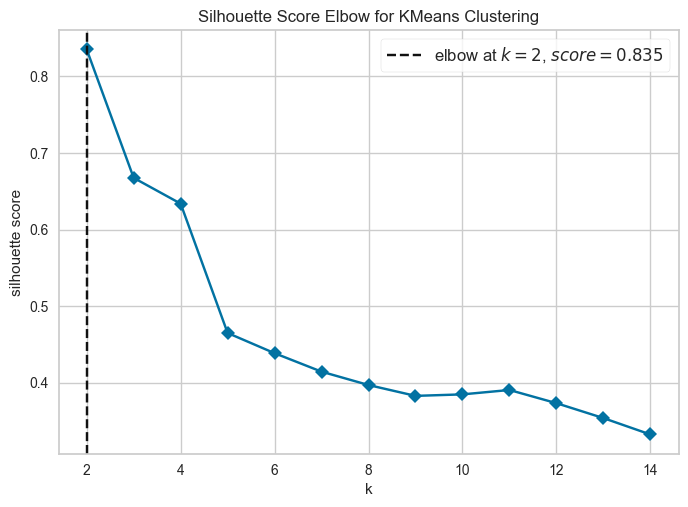

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [60]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 15), metric="silhouette", timings=False)
visualizer.fit(df_scaled)
visualizer.show()

Utilizando la técnica del codo y el preproceso seleccionado obtenemos dos clusters, $k = 2$, y un índice de silhouette de 0.835 (cercano a 1). 

Esto significa que los datos parecen agruparse bien en dos clústeres y que no hay solapamiento significativo entre ellos.

In [61]:
model_kmeans = KMeans(n_clusters=2)

km_fit = model_kmeans.fit(df_scaled)
labels = km_fit.labels_

### Metrics

In [62]:
clustering_metrics(df_scaled, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.83521,0.240917,5689
1,0.83521,0.240917,4603


Vemos que obtenemos un índice de Davies-Bouldin de 0.24, cuyo valor cercano a 0 indica una compacidad de los clústeres y separación entre ellos adecuada.

Además, mirando la cardinalidad de los clústeres podemos comprobar que ambos tienen un buen tamaño, sin desbalanceos acusados.

### Cluster exploration

En esta sección compararemos los clústeres obtenidos para identificar sus propiedades.

In [65]:
df_kmeans = df_scaled.copy()

df_kmeans['cluster'] = km_fit.labels_

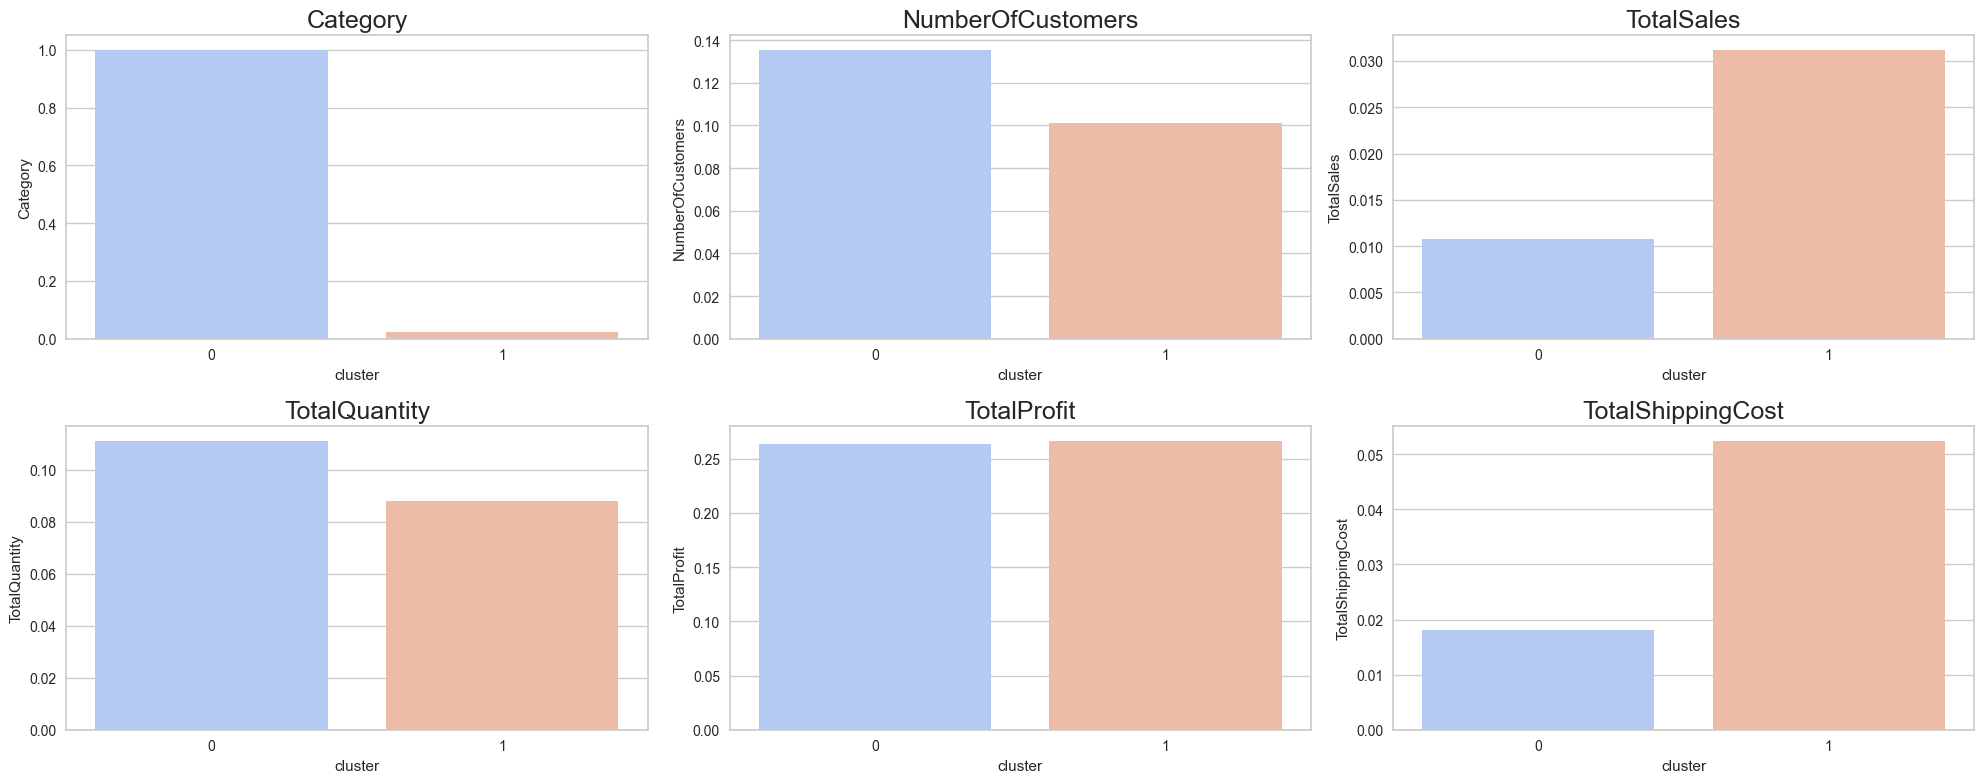

In [66]:
plot_clusters(df_kmeans)

Parece lo que caracteriza a estos clústeres son las categorías de los productos, y en, consecuencia el resto de variables.

### Radar plot

Realizando un diagrama de radar también podemos comprobar las diferencias entre clústeres. Representemos las variables numéricas.

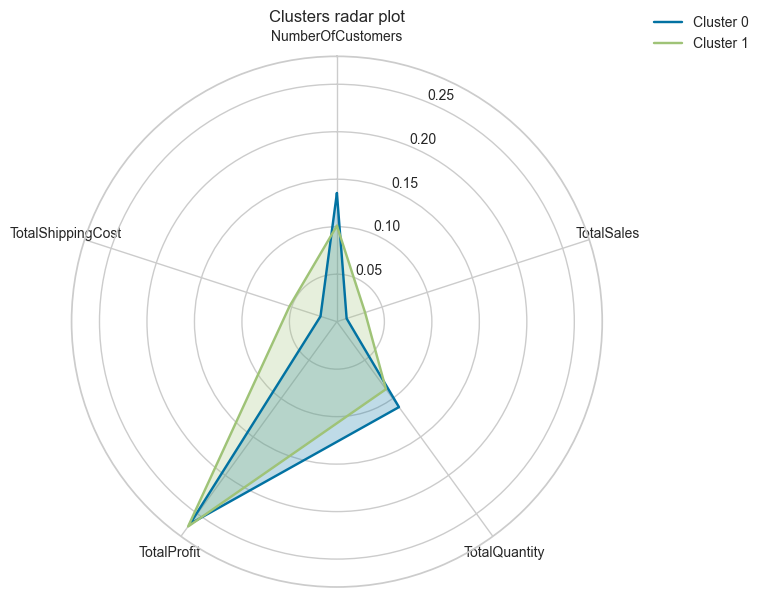

In [ ]:
variables = ['NumberOfCustomers', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_kmeans, variables)

### Histograms

A continuación podemos ver de forma más detallada la distribución de las variables en función del cluster. Podemos comprobar que efectivamente hay una división por categorías y que el resto de variables se distribuyen en función de las características de cada categoría.

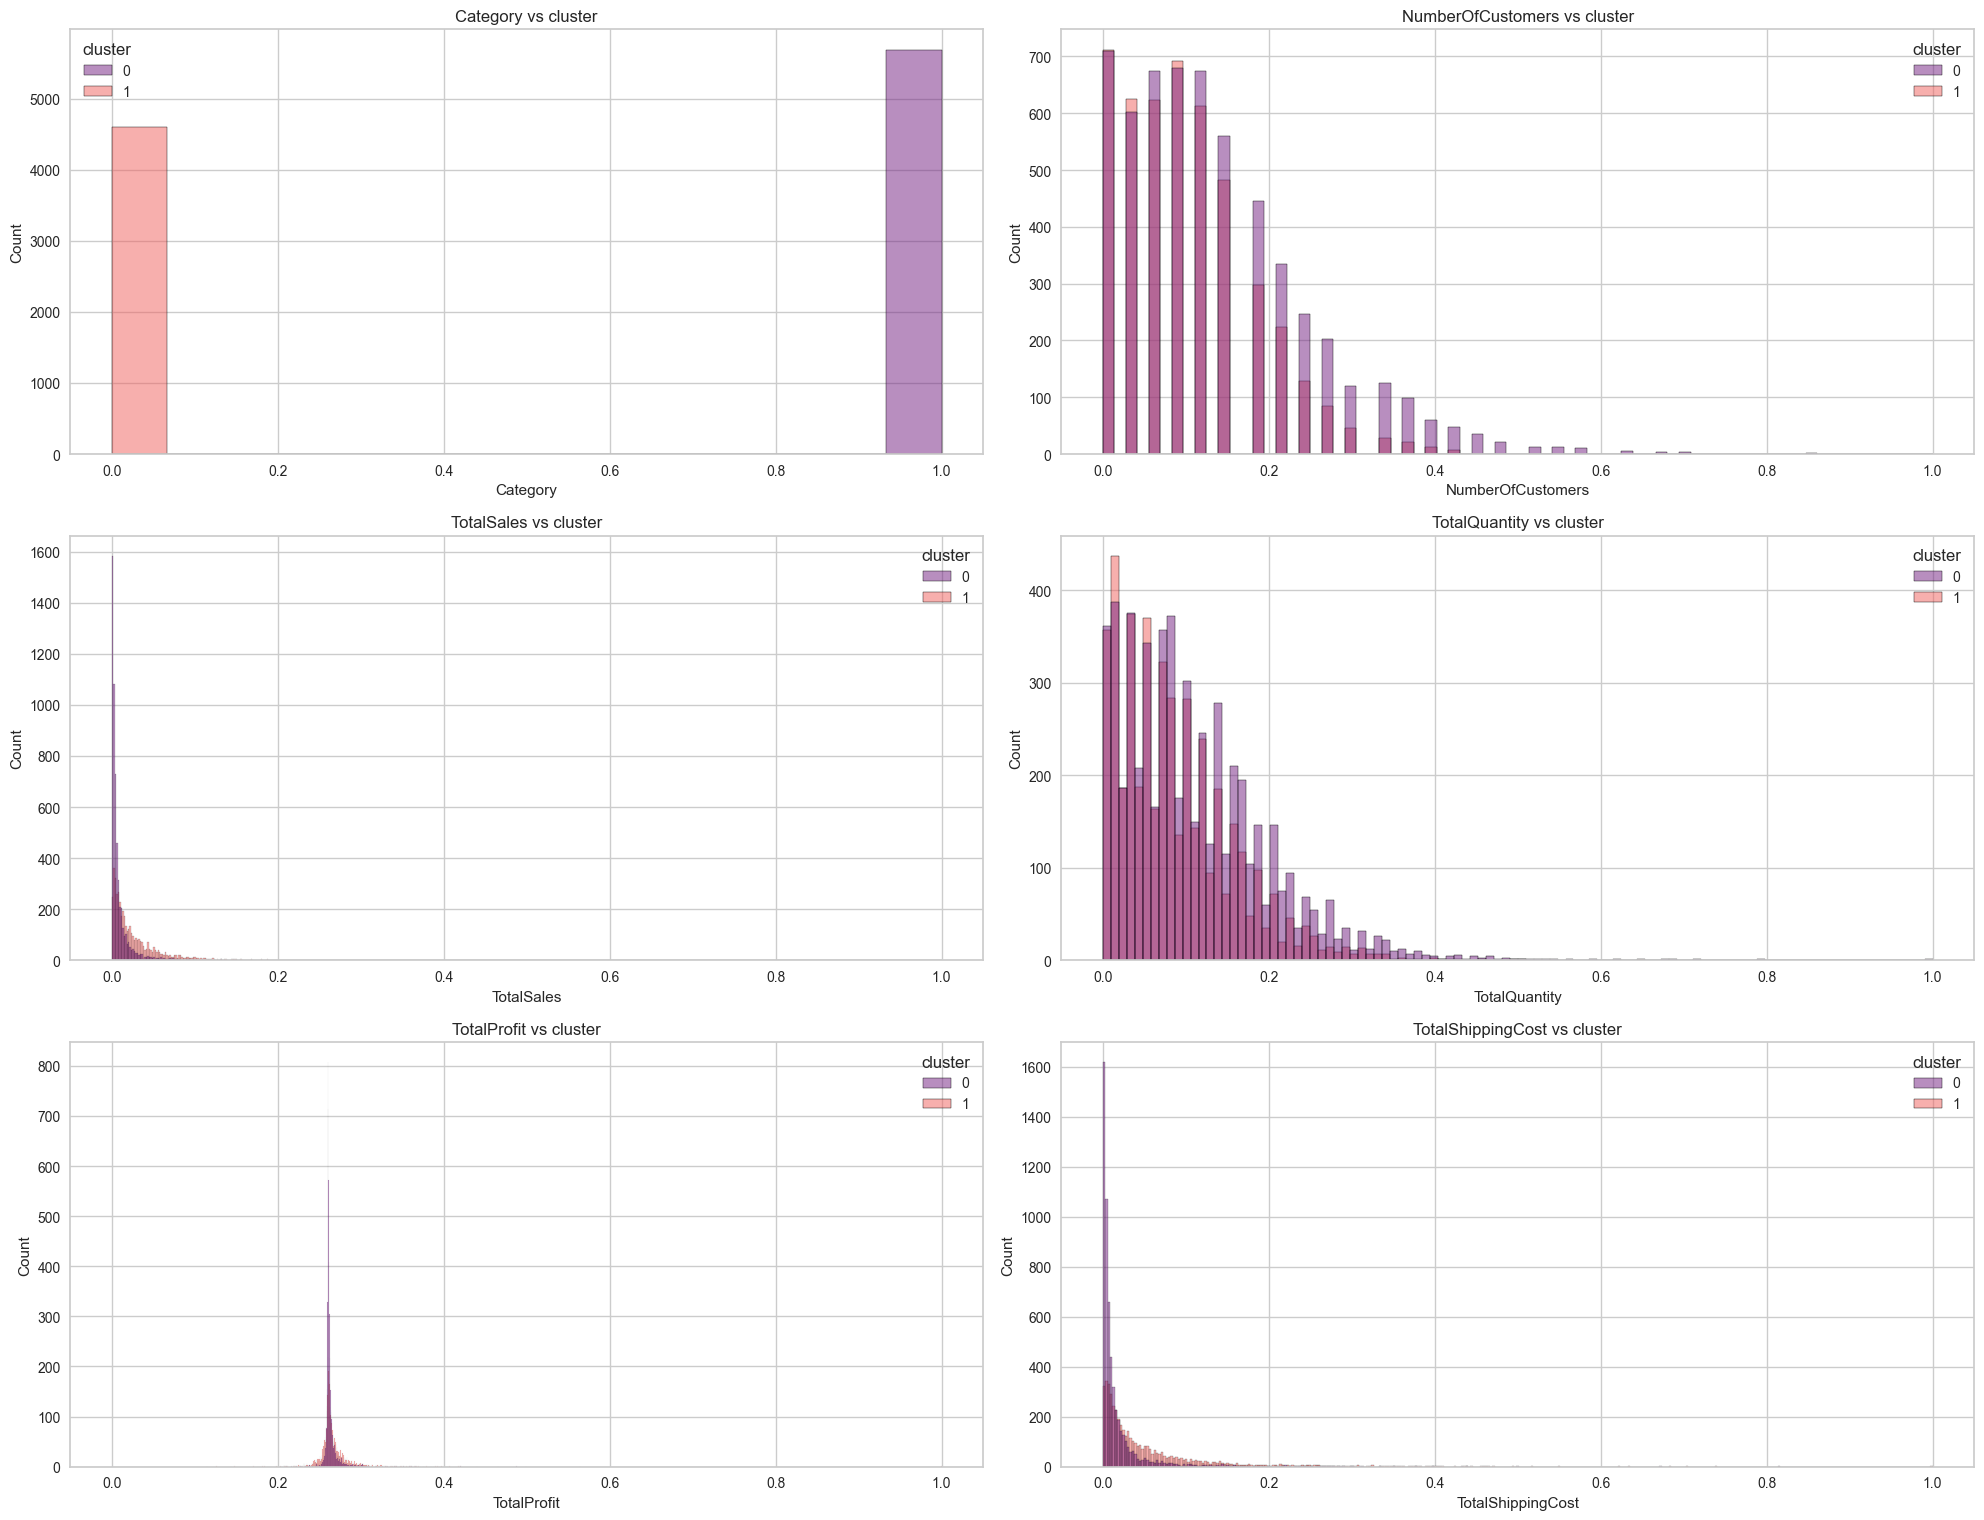

In [67]:
plot_relation_tv(df_kmeans, 'cluster', size=(20, 20), n_cols = 2)

---

## Agglomerative clustering

En esta ocasión vamos a emplear un modelo de clustering jerárquico aglomerativo.

Comencemos visualizando los dendrogramas asociados a cada tipo de linkage que podemos utilizar.

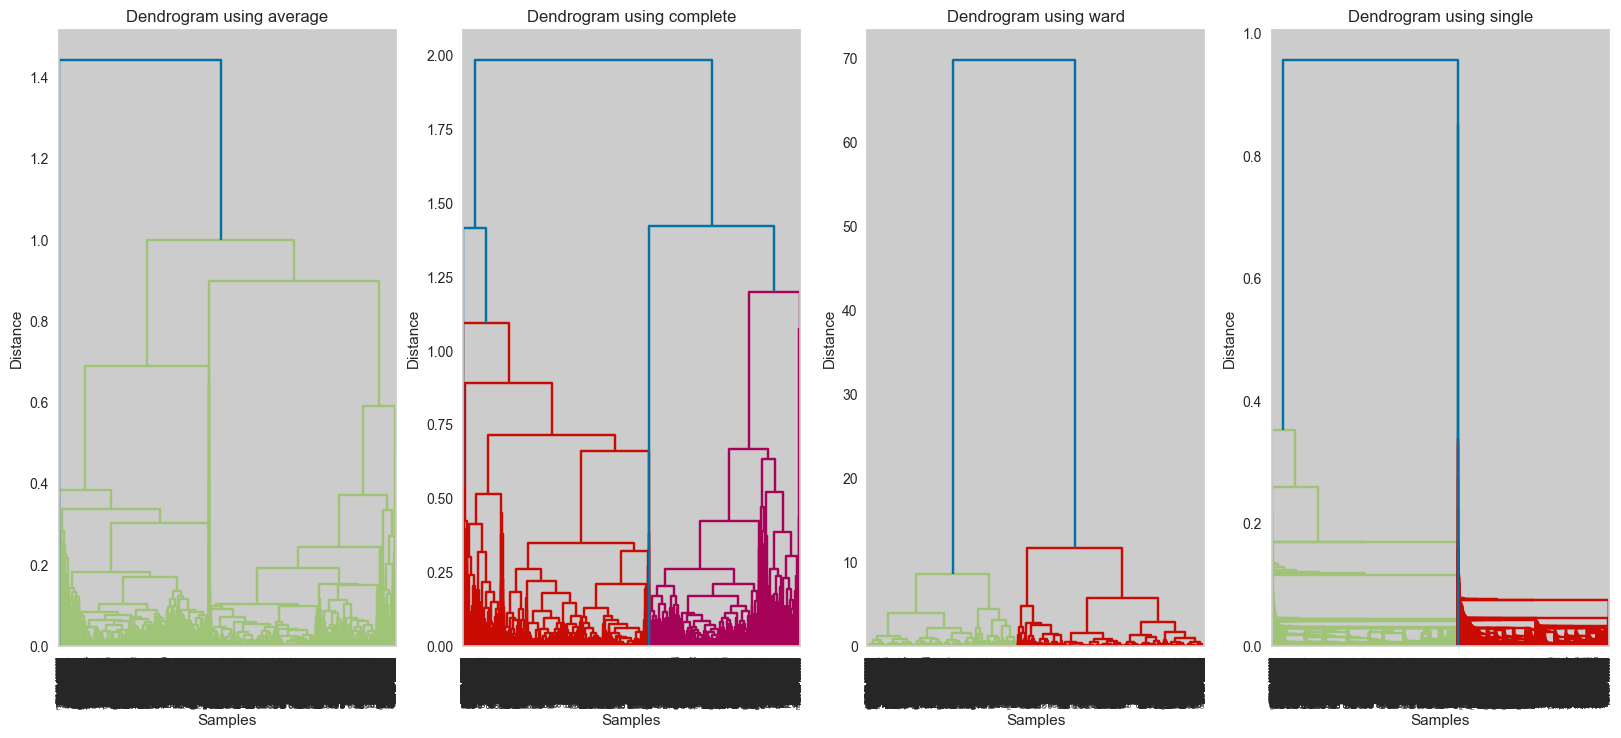

In [68]:
df_copy = df_scaled.copy()

plot_dendrogram(df_copy)

In [69]:
results_df = agglomerative_methods(df_copy)

Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.


In [70]:
best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

best_model

linkage                           complete
metric                           euclidean
silhouette_score                   0.83521
davies_bouldin_index              0.240917
cluster_cardinality     {0: 4603, 1: 5689}
n_cluster                                2
balance_score                     1.235933
ranking_score                     -0.64164
Name: 0, dtype: object

El mejor modelo utiliza un linkege 'complete' y una métrica euclídea.

In [71]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_scaled)
agglo_labels = agglo_fit.labels_

In [72]:
clustering_metrics(df_scaled, agglo_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.83521,0.240917,4603
1,0.83521,0.240917,5689


Las métricas y los clústeres obtenidos son prácticamente idénticas que en el clustering por K-means.

In [73]:
df_agg = df_scaled.copy()
df_agg["cluster"] = agglo_labels

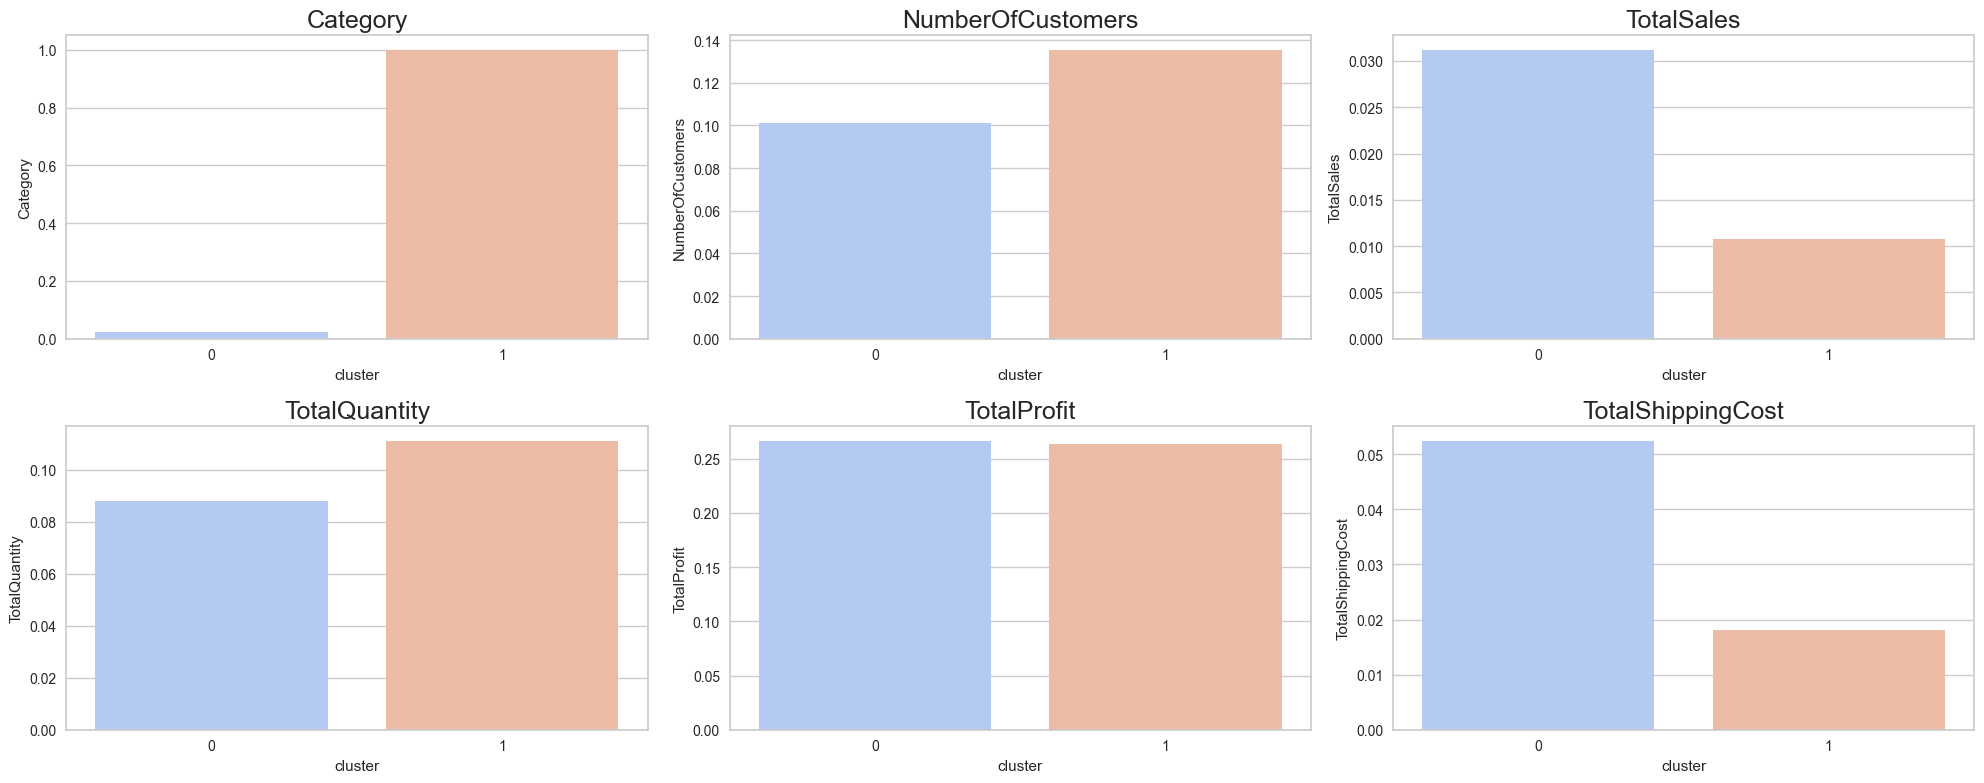

In [74]:
plot_clusters(df_agg)

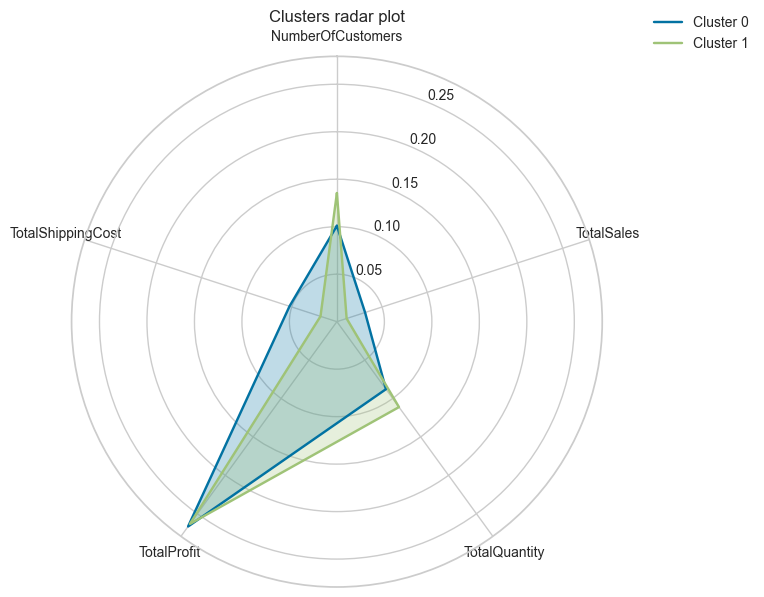

In [76]:
# Select variables to display in radar plot
variables = ['NumberOfCustomers', 'TotalSales',
       'TotalQuantity', 'TotalProfit', 'TotalShippingCost']

plot_radar(df_agg, variables)

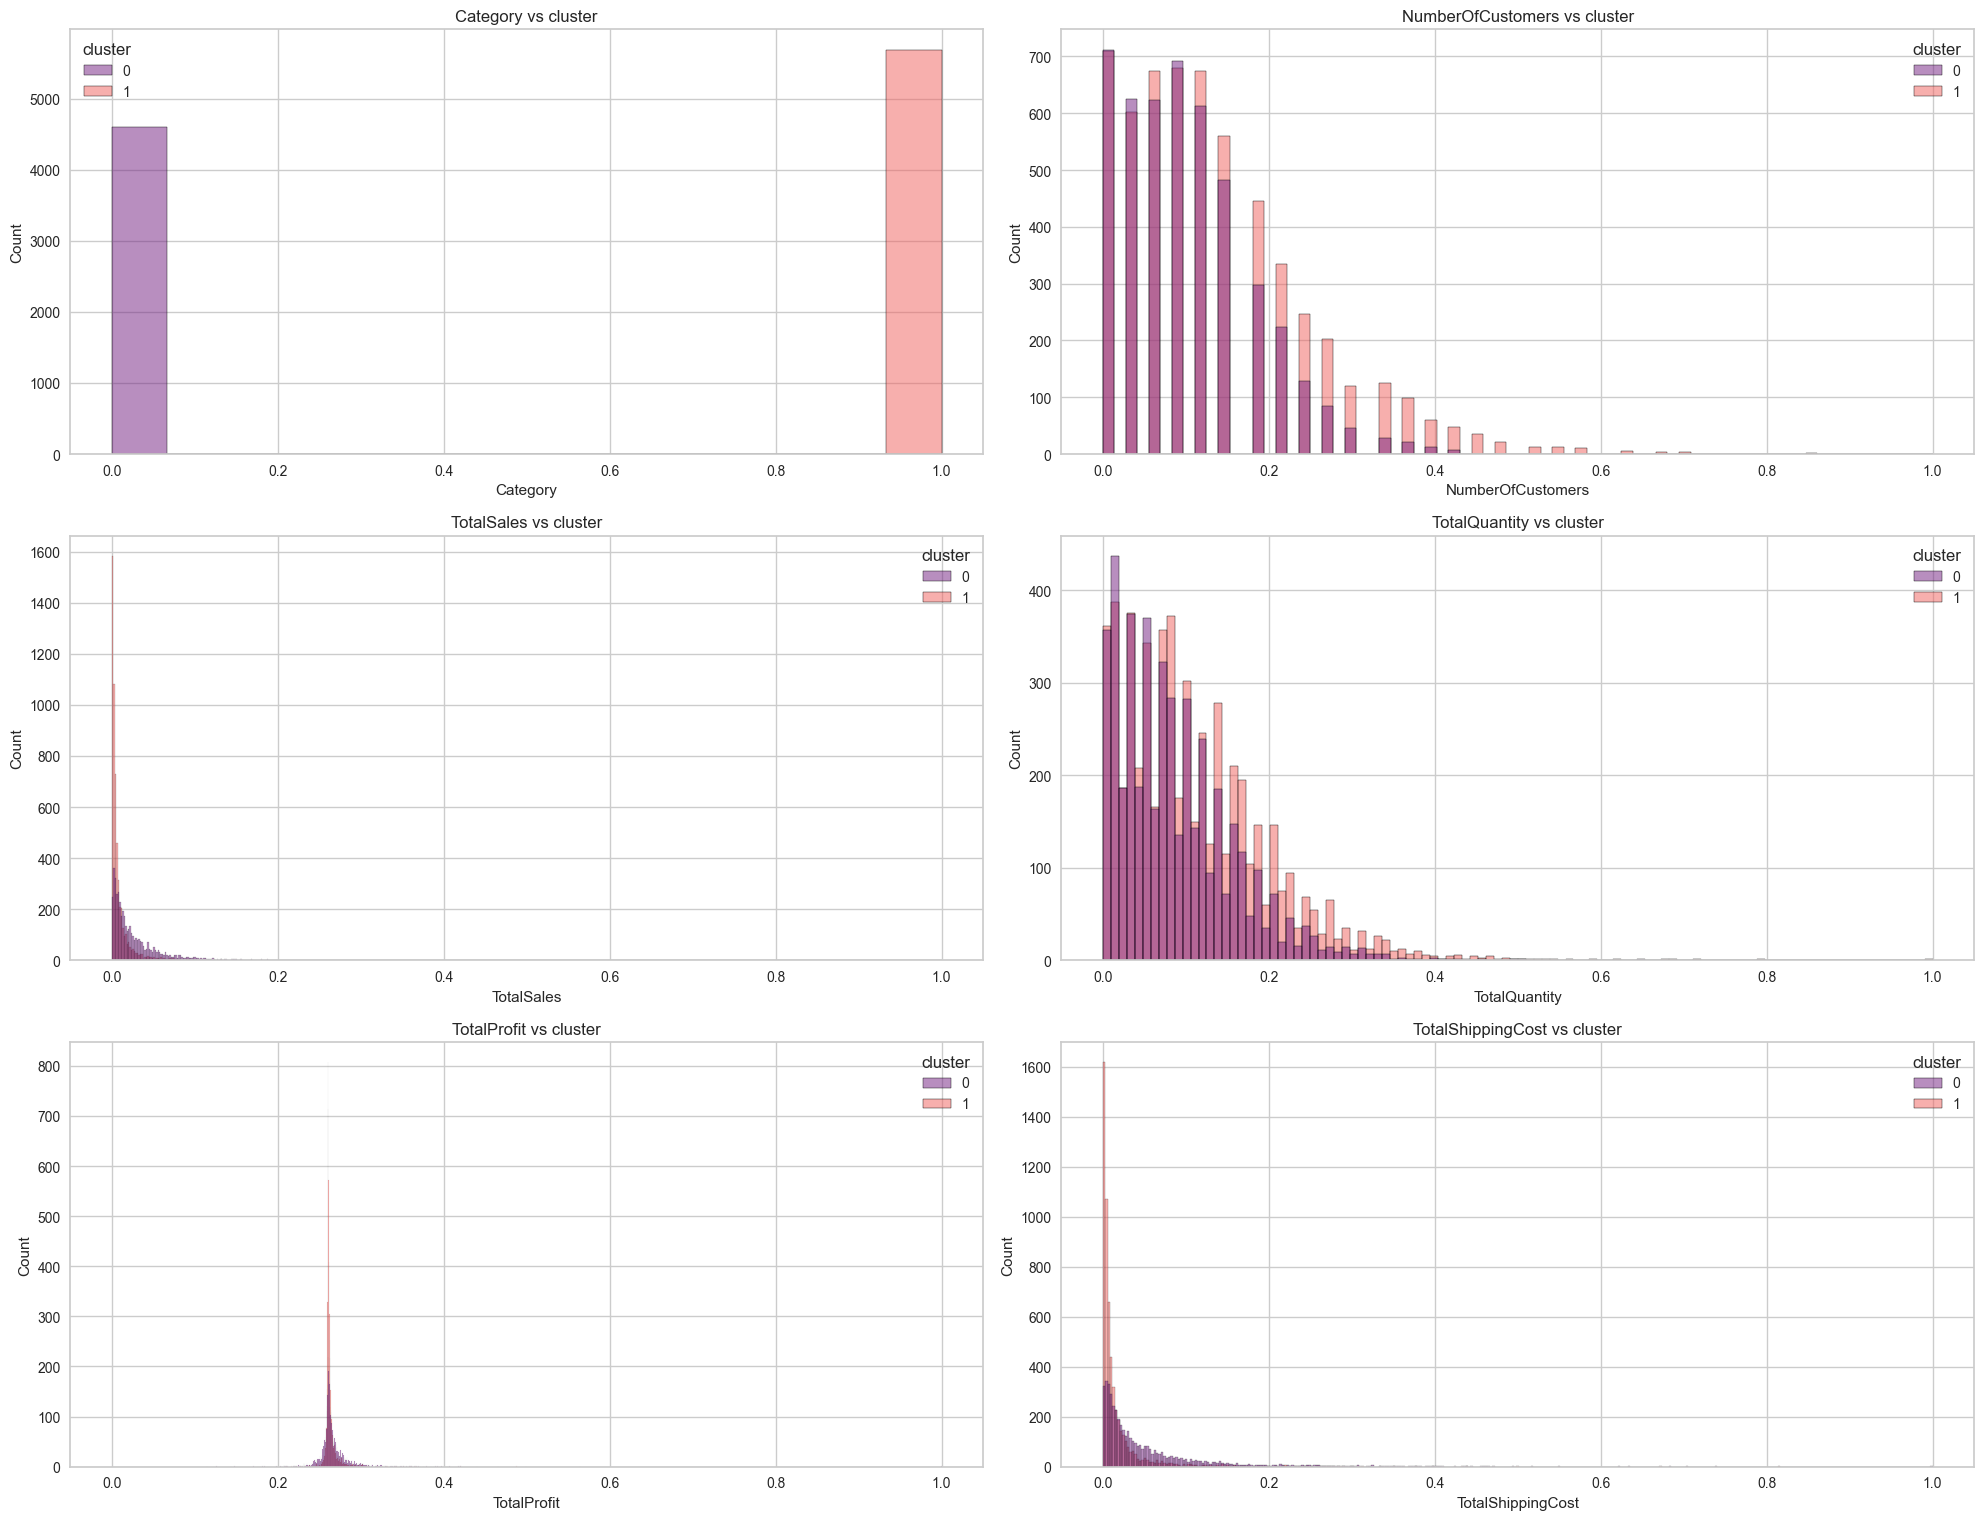

In [77]:
plot_relation_tv(df_agg, 'cluster', size=(20,20), n_cols = 2)

## Spectral clustering

This method takes a long time to run on this dataset, so we will discard it for now.

## DBSCAN Clustering

In [79]:
dbscan_methods(df_scaled, eps_values=[0.1, 0.5, 1], min_samples_values=[3, 5, 10, 15])

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
4,0.5,3,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
5,0.5,5,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
6,0.5,10,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
7,0.5,15,0.835081,0.191067,"{-1: 1, 0: 4602, 1: 5689}"
1,0.1,5,0.813099,1.074318,"{-1: 57, 0: 4576, 1: 5659}"
2,0.1,10,0.811265,1.051677,"{-1: 69, 0: 4568, 1: 5655}"
3,0.1,15,0.804207,1.058428,"{-1: 92, 0: 4556, 1: 5644}"
0,0.1,3,0.738094,0.994823,"{-1: 42, 0: 4578, 1: 5660, 2: 4, 3: 8}"
8,1.0,3,-1.000000,NaN,{'Unique cluster': 10292}
9,1.0,5,-1.000000,NaN,{'Unique cluster': 10292}


En este caso, diferenctes combinaciones de `epsilon` y `min_samples`, nos llevan a la conclusión de que los únicos modelos aceptables son muy similares a los obtenidos con los algoritmos anteriores con la salvedad de que en esta ocasión se genera un tercer cluster con un único elemento.

Este elemento podría tratarse de un valor suficientemente atípico como para no ser capturado por ninguno de los otros dos clústeres. Esto es perfectamente posible pero dejamos su estudio para posteriores análisis.

For now, we will discard the DBSCAN method for clustering.